## ANZ - Task 2

### Setup

In [1]:
# Handling data
import pandas as pd
import numpy as np
import datetime as dt

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Style setup
import matplotlib as mpl
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 16)
mpl.rc('ytick', labelsize = 12)
plt.style.use('fivethirtyeight')

### Loading data

In the next cells i am going to load the data. Furthermore, i will add to variable about the month of the transaction and the specific minute of the day in which it took place.

In [2]:
df = pd.read_excel(r'C:\Users\Aless\Downloads\ANZ synthesised transaction dataset (1).xlsx')
df.extraction = pd.to_datetime(df.extraction)
df['month'] = df.date.apply(lambda x: x.month)
df['time'] = df.extraction.apply(lambda x: x.hour * 60 + x.minute)
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,month,time
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,QLD,2018-08-01 01:01:15+00:00,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit,8,61
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,NSW,2018-08-01 01:13:45+00:00,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit,8,73
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,NSW,2018-08-01 01:26:15+00:00,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit,8,86
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,QLD,2018-08-01 01:38:45+00:00,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit,8,98
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,QLD,2018-08-01 01:51:15+00:00,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit,8,111


### Feature creation

#### Defining the target variable

First i am going to need to compute the target variable of our analysis, the annual salary. In order to compute it i used the following formula:

*annual salary = (last_balance - oldest_balance + total_expenditure) * 4*

Since i have data for 3 months, i used the '*4' as a proxy for annual salary (even though there are some tiny differences regarding the days). I am going to create a new dataframe about customers with the information needed for regression

In [3]:
df_cust = pd.DataFrame(df.groupby('account').age.mean()).reset_index()

def get_annual_salary(x):
    cust = df.loc[(df.account == x)]
    oldest_day = cust.loc[cust.date == min(cust.date)]
    first_balance = oldest_day.loc[oldest_day.time == min(oldest_day.time)]
    last_day = cust.loc[cust.date == max(cust.date)]
    last_balance = last_day.loc[last_day.time == max(last_day.time)]
    return (last_balance.balance.iloc[0] - first_balance.balance.iloc[0] + sum(cust.amount)) * 4

df_cust['salary'] = df.account.apply(get_annual_salary)

#### Creating regressors

Next i will create some variable that will help me in predicting the annual salary:
    
The gender of the customer, his monthly expenditures, their standard deviation and the percentage of total transactions did with a credit card

In [4]:
def get_monthly_exp(x):
    cust = df.loc[(df.account == x)]
    return sum(cust.amount) / 3

df_cust['expenditure'] = df.account.apply(get_monthly_exp)

df['int_gender'] = df.gender.apply(lambda x: 1 if x == 'F' else 0)
df_cust['gender'] = df.groupby('account').int_gender.mean().values

def get_credit_card_usage(x):
    cust = df.loc[(df.account == x)]
    return cust.movement.value_counts(normalize = True).loc['credit']

df_cust['cc_usage'] = df.account.apply(get_credit_card_usage)

def get_exp_std(x):
    cust = df.loc[(df.account == x)]
    return cust.amount.std()

df_cust['exp_std'] = df.account.apply(get_exp_std)
df_cust.set_index('account', inplace = True)
df_cust.head()

,age,salary,expenditure,gender,cc_usage,exp_std
account,,,,,,
ACC-1037050564,40,113244.24,8737.196667,1,0.024221,168.822926
ACC-1056639002,22,113244.24,8737.196667,0,0.024221,168.822926
ACC-1199531521,52,104047.20,7898.816667,0,0.042904,245.088217
ACC-1217063613,27,92808.96,6428.813333,1,0.050193,190.426861
ACC-1222300524,38,113244.24,8737.196667,0,0.024221,168.822926


### Preprocessing

I am goign to apply a second degree polynomial on the training set in order to obtain a more accurate model and at the top of that i will use the minmax scaler. Then i will wrap everything togheter using a pipeline 

In [5]:
from sklearn.model_selection import train_test_split

x = df_cust.drop('salary', axis = 1).values
y = df_cust.salary.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

preprocessing_pipeline = Pipeline([('poly' , PolynomialFeatures(degree = 2)),
                                   ('scaler' , MinMaxScaler())])
preprocessing_pipeline.fit(x_train, y_train)
data_train_scaled = preprocessing_pipeline.transform(x_train)

### Linear regression

First let us start to evaluate a linear regression with 10 folds cross validation. I am using a high number of folds since the training set is small and so prone to overfitting

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(data_train_scaled, y_train)

from sklearn.model_selection import cross_val_score

reg_scores = cross_val_score(lin_reg, data_train_scaled, y_train, cv = 10, scoring = 'neg_mean_absolute_error')
print('The Linear Regression scored a mean absolute error of {} with a cross validation of 10 folds'.format(np.round(-reg_scores.mean(), 2)))

The Linear Regression scored a mean absolute error of 14058.02 with a cross validation of 10 folds


The mean absolute error is not that good, we can try to test powerful model

### Decision tree

In [7]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth = 5)
tree.fit(data_train_scaled, y_train)
tree_scores = cross_val_score(tree, data_train_scaled, y_train, cv = 10, scoring = 'neg_mean_absolute_error')
print('The decision tree scored a mean absolute error of {} with a cross validation of 10 folds'.format(np.round(-tree_scores.mean(), 2)))

The decision tree scored a mean absolute error of 8246.06 with a cross validation of 10 folds


The decision tree perfomed significantly better than the regression

### XGBoost

Last we can try one of the most powerful regressor in machine learning: extrreme gradient boost. Since XGB has a lot of different hyperparameters to tune i will try to optimize the model through a randomized research in the hyperparameters' space

In [8]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.2,
                          max_depth = 5, alpha = 10)
xg_reg.fit(data_train_scaled, y_train)
xg_scores = cross_val_score(xg_reg, data_train_scaled, y_train, cv = 10, scoring = 'neg_mean_absolute_error')
print('Extreme Gradient Boost scored a mean absolute error of {} with a cross validation of 10 folds'.format(np.round(-xg_scores.mean(), 2)))

Extreme Gradient Boost scored a mean absolute error of 7962.29 with a cross validation of 10 folds


#### Hyperparameters tuning

In [9]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators' : [50, 75, 100, 125, 150, 175, 200], 
              'eta' : [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5], 
              'gamma' : [0, 0.25, 0.4, 0.5, 0.75, 1.], 
              'max_depth' : [2, 3, 4, 5],
              'alpha' : [0.0, 0.05, 0.1, 0.2]}
              
grid_search = RandomizedSearchCV(xg_reg, param_grid, cv = 5,
                                 scoring = 'neg_mean_absolute_error', return_train_score = True)
grid_search.fit(data_train_scaled, y_train)
print(grid_search.best_params_)

model_tuned = grid_search.best_estimator_
xg_tuned_scores = cross_val_score(model_tuned, data_train_scaled, y_train, cv = 10, scoring = 'neg_mean_absolute_error')
print('Mae of Extreme Gradient Boost after tuning with a cross validation of 10 folds: {}'.format(np.round(-xg_tuned_scores.mean(), 2)))

{'n_estimators': 150, 'max_depth': 2, 'gamma': 0.25, 'eta': 0.25, 'alpha': 0.0}
Mae of Extreme Gradient Boost after tuning with a cross validation of 10 folds: 6875.76


We managed to reduce again the error. Now that we are satisfied we can test the model in production

#### Evaluation on production

Mean absolute error on production:  4644.87
Mape on production: 3.24%


Text(0.5, 1.0, 'Comparing predicted and true salaries')

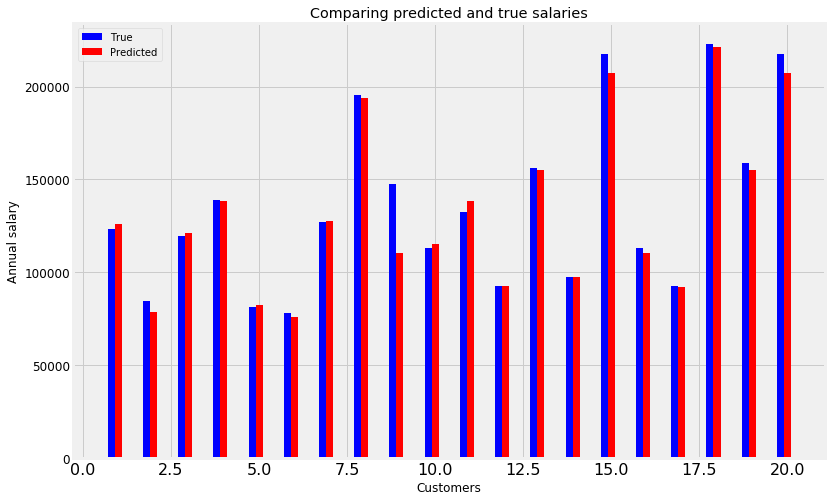

In [10]:
from sklearn.metrics import mean_absolute_error


data_test_scaled = preprocessing_pipeline.transform(x_test)
y_pred_xgb = model_tuned.predict(data_test_scaled)
xgb_mae = mean_absolute_error(y_pred_xgb, y_test)
print('Mean absolute error on production: ', np.round(xgb_mae, 2))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred_xgb)
print('Mape on production: {}%'.format(np.round(mape, 2)))

plt.figure(figsize = (12, 8))

x = np.array([i for i in range(1, len(x_test) + 1)])
y1 = y_test
y2 = y_pred_xgb

ax = plt.subplot(111)
ax.bar(x - 0.2, y1, width = 0.2, color = 'b', align = 'center', label = 'True')
ax.bar(x, y2, width = 0.2, color = 'r', align = 'center', label = 'Predicted')
ax.set_xlabel('Customers'); ax.set_ylabel('Annual salary')
ax.legend(); plt.title('Comparing predicted and true salaries')

The model managed to extract meanful information from the transaction data. A mape of 3.24% is acceptable, so the model can be used to create customers segments. If we want to achieve higher perfomance (and so a lower mean absolute error) we can restart to work on the initial dataset in order to extract more features. Another way can be to add logarithmic and exponential functions to our customers dataframe: doing so even though we have the same amount of starting regressors we can increase the the ability of the model to capture complex trends.